In [1]:
import pandas as pd
import json, os

import tensorflow as tf
import numpy as np
import csv
from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification #, BertModel, BertTokenizer, TFBertForSequenceClassification
import matplotlib.pyplot as plt
import random
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from collections import OrderedDict
import time
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import random
import io

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Embedding, MaxPool1D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.initializers import glorot_uniform, RandomUniform, lecun_uniform, Constant
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from collections import OrderedDict
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPool1D
import tensorflow.keras.backend as K

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D

from sklearn.metrics import classification_report
from keras_preprocessing.text import tokenizer_from_json

import nltk
from nltk.tokenize import word_tokenize

import seaborn as sns

D:\anaconda3\envs\tfgpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 123
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [3]:
embeddings = ["w2v", "ft", "bert", "codebert"]
embedding = embeddings[3]

Choose a project among Chrome and Linux or the full dataset

In [4]:
#data = pd.read_csv(os.path.join('..','data', 'full_data_reduced.csv'))
#data = pd.read_csv(os.path.join('..','data', 'chrome_data_reduced.csv'))
data = pd.read_csv(os.path.join('..','data', 'linux_data_reduced.csv'))

Shuffle the dataset before starting operating on it

In [5]:
data = data.sample(frac=1, random_state=seed).reset_index(drop=True)

In [6]:
print(data.head())

                                                func  vul  length
0  static inline void __ap_schedule_poll_timer(vo...    0      30
1  static int sctp_autobind(struct sock *sk)\n{\n...    0      36
2  static ssize_t ucma_init_qp_attr(struct ucma_f...    0      88
3  static void __blk_mq_requeue_request(struct re...    0      24
4  static void vhost_net_flush(struct vhost_net *...    0      37


In [7]:
np.max(data["length"])

237

In [8]:
word_counts = data["func"].apply(lambda x: len(x.split()))
max_length = word_counts.max()
print("Maximum number of words:", max_length)


Maximum number of words: 237


In [9]:
print(data["vul"].value_counts())

print((data["vul"].value_counts()[1]/data["vul"].value_counts()[0])*100, '%')

0    43024
1     1439
Name: vul, dtype: int64
3.344644849386389 %


PRE_PROCESSING

In [10]:
def padSequences(sequences, max_len):
    lines_pad = []
    for sequence in sequences:
        seq = sequence['input_ids'].numpy()[0]
        if len(seq) < max_len:
            for i in range(len(seq), max_len):
                seq = np.append(seq, 0)
        lines_pad.append(seq)
    return lines_pad


In [11]:
nltk.download('punkt')

tokenized_list = [word_tokenize(sentence) for sentence in data["func"].tolist()]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\iliaskaloup\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


BERT pre-trained embeddings

In [12]:
if embedding == "bert":
    model_variation = "bert-base-uncased" # "roberta-base"
    tokenizer = AutoTokenizer.from_pretrained(model_variation)
    bert = TFAutoModel.from_pretrained(model_variation)

In [13]:
if embedding == "bert":
    bert_embeddings = bert.get_input_embeddings()
    embedding_matrix = bert_embeddings.weights[0].numpy()
    num_words = len(embedding_matrix)
    print(num_words)
    dim = len(embedding_matrix[0])
    print(dim)

In [14]:
if embedding == "bert":
    sentences = data["func"].tolist()
    sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="tf").numpy() for sente in sentences] # Tokenize the complete sentences


In [15]:
if embedding == "bert":
    lines_pad = []
    for seq in sequences:
        lines_pad.append(seq[0])

    lines_pad = pad_sequences(lines_pad, padding = 'post', maxlen = 512)
    lines_pad

CodeBERT pre-trained CPP embeddings

In [16]:
if embedding == "codebert":
    model_variation = "microsoft/codebert-base-mlm" # "neulab/codebert-cpp"
    tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=False) # , do_lower_case=True
    codebert = TFAutoModel.from_pretrained(model_variation) # , from_pt=True

Some layers from the model checkpoint at microsoft/codebert-base-mlm were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at microsoft/codebert-base-mlm.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [17]:
if embedding == "codebert":
    codebert_embeddings = codebert.get_input_embeddings()
    embedding_matrix = codebert_embeddings.weights[0].numpy()
    num_words = len(embedding_matrix)
    print(num_words)
    dim = len(embedding_matrix[0])
    print(dim)

50265
768


In [18]:
if embedding == "codebert":
    sentences = data["func"].tolist()
    sequences = [tokenizer(sente, return_tensors="tf", truncation=True, add_special_tokens=False) for sente in sentences]

In [19]:
def get_max_len(sequences):
    max_len = 0
    
    for seq in sequences:
        if len(seq['input_ids'].numpy()[0]) > max_len:
            max_len = len(seq['input_ids'].numpy()[0])
    
    return max_len

In [20]:
max_len = get_max_len(sequences)
print(max_len)

512


In [21]:
if embedding == "codebert":
    lines_pad = padSequences(sequences, max_len)
    lines_pad = [arr.tolist() for arr in lines_pad]
    lines_pad = np.array(lines_pad)

CROSS-VALIDATION

In [22]:
# Evaluation functions
def recall_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

def precision_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision

def f1_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f1 = 2*((prec*rec)/(prec+rec+K.epsilon()))
    return f1

def f2_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f2 = 5*((prec*rec)/(4*prec+rec+K.epsilon()))
    return f2

In [26]:
# Deep Learning Models - Classifiers
def buildLstm(max_len, top_words, dim, seed, embedding_matrix):
    model=Sequential()
    #model.add(Embedding(input_dim=top_words+1, output_dim=dim, input_length=None, mask_zero=True))
    model.add(Embedding(input_dim=top_words, output_dim=dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))
    #model.add(SimpleRNN(300, dropout=0.3, stateful=False))
    model.add(LSTM(100, dropout=0.2, return_sequences=True, stateful=False))
    model.add(LSTM(50, dropout=0.1, stateful=False))
    #model.add(Bidirectional(LSTM(300, dropout=0.3, stateful=False)))
    #model.add(GRU(300, dropout=0.3, stateful=False))
    model.add(Activation('relu')) #dropout=0.2, recurrent_dropout=0.2, kernel_constraint=max_norm(3), bias_constraint=max_norm(3)
    model.add(BatchNormalization(momentum=0.0))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_metric])  
    return model

def buildCnn(max_len, top_words, dim, seed, embedding_matrix):
    cnn_model = Sequential()
    cnn_model.add(Embedding(top_words, dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))
    cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))
    '''cnn_model.add(MaxPooling1D(pool_size = 5))
    cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))
    cnn_model.add(MaxPooling1D(pool_size = 5))
    cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))'''
    cnn_model.add(GlobalMaxPool1D())
    #cnn_model.add(Dense(units = 128, activation = 'relu'))
    cnn_model.add(Dense(units = 1, activation = 'sigmoid'))
    cnn_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics=[f1_metric])
    return cnn_model


In [27]:
def runCrossVal(X, y, max_len, num_words, dim, seed, embedding_matrix, userModel):
    ############## cross validation
    scores=['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'f2']
    values = [np.array([]) for i in range(0, len(scores))]
    score_dict = OrderedDict(zip(scores, values))
    k=10
    f=0
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    
    nb_epoch = 100
    BS = 64
    print("Training...")
    milli_sec1 = int(round(time.time() * 1000))
    
    for train_index, test_index in kfold.split(X, y):
        f = f + 1
        print('fold number= ',f)
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = y[train_index], y[test_index]
        
        
#         #sampling
#         X_res, Y_res = RandomOverSampler(random_state=seed, sampling_strategy=0.5).fit_resample(X_train, Y_train)
#         #X_res, Y_res = RandomUnderSampler(random_state=seed, sampling_strategy=0.5).fit_resample(X_train, Y_train)
    
#         #shuffle dataset
#         X_resampled=pd.DataFrame(X_res)
#         Y_resampled=pd.DataFrame(Y_res)
#         newTrain=X_resampled.assign(Label=Y_resampled.values)
#         newTrain = shuffle(newTrain,random_state=seed)
#         X_train=np.array(newTrain.iloc[:, 0:-1 ])
#         X_train=pd.DataFrame(X_train)
#         Y_train=np.array(newTrain.iloc[:, -1 ])
#         Y_train=pd.DataFrame(Y_train)
        
        if userModel == "cnn":
            myModel = buildCnn(max_len, num_words, dim, seed, embedding_matrix) 
        elif userModel == "lstm":
            myModel = buildLstm(max_len, num_words, dim, seed, embedding_matrix)

        print("model summary\m", myModel.summary())
        csv_logger = CSVLogger('log.csv', append=True, separator=',')
        es = EarlyStopping(monitor='val_f1_metric', mode='max', verbose=1, patience=10)
        mc = ModelCheckpoint('best_model.h5', monitor='val_f1_metric', mode='max', verbose=1, save_best_only=True)
        print(type(X_train))
        history = myModel.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = nb_epoch, batch_size = BS, shuffle=True, verbose=1, callbacks=[csv_logger,es,mc])
        
        #load best model
        #model = load_model('best_model.h5')
        myModel.load_weights("best_model.h5")
        
        scores = myModel.evaluate(X_test, Y_test, verbose=0)
        #predictions = myModel.predict_classes(X_test, verbose=0)
        predScores = myModel.predict(X_test)
        predictions = (predScores > 0.5).astype("int32")
        
        accuracy=accuracy_score(Y_test, predictions)
        precision=precision_score(Y_test, predictions)
        recall=recall_score(Y_test, predictions)
        f1=f1_score(Y_test, predictions)
        roc_auc=roc_auc_score(Y_test, predictions)
        f2=5*precision*recall / (4*precision+recall)
        
        cm = confusion_matrix(Y_test, predictions, labels=[0, 1])
        #print(cm)
        sns.heatmap(cm, annot=True)
        tn, fp, fn, tp = cm.ravel()
        
        print("TP=",tp)
        print("TN=",tn)
        print("FP=",fp)
        print("FN=",fn)
        
        acc = ((tp+tn)/(tp+tn+fp+fn))
        
        print("Accuracy:%.2f%%"%(acc*100))
        print("Precision:%.2f%%"%(precision*100))
        print("Recall:%.2f%%"%(recall*100))
        print("F1 score:%.2f%%"%(f1*100))
        print("Roc_Auc score:%.2f%%"%(roc_auc*100))
        print("F2 score:%.2f%%"%(f2*100))
        print(classification_report(Y_test, predictions))
        
        del myModel
        
        score_dict['accuracy'] = np.append(score_dict['accuracy'], accuracy)
        score_dict['precision'] = np.append(score_dict['precision'], precision)
        score_dict['recall'] = np.append(score_dict['recall'], recall)
        score_dict['f1'] = np.append(score_dict['f1'], f1)
        score_dict['roc_auc'] = np.append(score_dict['roc_auc'], roc_auc)
        score_dict['f2'] = np.append(score_dict['f2'], f2)
        
    milli_sec2 = int(round(time.time() * 1000))
    print("Cross Validation is completed after", milli_sec2-milli_sec1)
    
    print("accuracy: %.2f%% (%.2f%%)" % (score_dict['accuracy'].mean()*100, score_dict['accuracy'].std()*100))
    print("precision: %.2f%% (%.2f%%)" % (score_dict['precision'].mean()*100, score_dict['precision'].std()*100))
    print("recall: %.2f%% (%.2f%%)" % (score_dict['recall'].mean()*100, score_dict['recall'].std()*100))
    print("f1: %.2f%% (%.2f%%)" % (score_dict['f1'].mean()*100, score_dict['f1'].std()*100))
    print("roc_auc: %.2f%% (%.2f%%)" % (score_dict['roc_auc'].mean()*100, score_dict['roc_auc'].std()*100))
    print("f2: %.2f%% (%.2f%%)" % (score_dict['f2'].mean()*100, score_dict['f2'].std()*100))

Training...
fold number=  1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 768)         38603520  
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 100)         347600    
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 38,981,571
Trainable params: 377,951
Non-trainable params: 38,603,620
________

626/626 [==============================] - 54s 85ms/step - loss: 0.0588 - f1_metric: 0.4037 - val_loss: 0.0682 - val_f1_metric: 0.2491

Epoch 00007: val_f1_metric did not improve from 0.55307
Epoch 8/100
626/626 [==============================] - 55s 87ms/step - loss: 0.0570 - f1_metric: 0.4566 - val_loss: 0.0695 - val_f1_metric: 0.1571

Epoch 00008: val_f1_metric did not improve from 0.55307
Epoch 9/100
626/626 [==============================] - 621s 994ms/step - loss: 0.0554 - f1_metric: 0.4485 - val_loss: 0.0695 - val_f1_metric: 0.4361

Epoch 00009: val_f1_metric did not improve from 0.55307
Epoch 10/100
626/626 [==============================] - 800s 1s/step - loss: 0.0525 - f1_metric: 0.4771 - val_loss: 0.0835 - val_f1_metric: 0.5064

Epoch 00010: val_f1_metric did not improve from 0.55307
Epoch 11/100
626/626 [==============================] - 800s 1s/step - loss: 0.0506 - f1_metric: 0.4874 - val_loss: 0.0815 - val_f1_metric: 0.4526

Epoch 00011: val_f1_metric did not improve fro

626/626 [==============================] - 344s 541ms/step - loss: 0.1935 - f1_metric: 0.1353 - val_loss: 0.1223 - val_f1_metric: 0.1946

Epoch 00001: val_f1_metric improved from -inf to 0.19456, saving model to best_model.h5
Epoch 2/100
626/626 [==============================] - 328s 523ms/step - loss: 0.1210 - f1_metric: 0.1705 - val_loss: 0.1189 - val_f1_metric: 0.1286

Epoch 00002: val_f1_metric did not improve from 0.19456
Epoch 3/100
626/626 [==============================] - 328s 523ms/step - loss: 0.0766 - f1_metric: 0.3052 - val_loss: 0.1095 - val_f1_metric: 0.5408

Epoch 00003: val_f1_metric improved from 0.19456 to 0.54078, saving model to best_model.h5
Epoch 4/100
626/626 [==============================] - 334s 533ms/step - loss: 0.0654 - f1_metric: 0.3683 - val_loss: 0.0644 - val_f1_metric: 0.5352

Epoch 00004: val_f1_metric did not improve from 0.54078
Epoch 5/100
626/626 [==============================] - 351s 560ms/step - loss: 0.0636 - f1_metric: 0.3820 - val_loss: 0.0

KeyboardInterrupt: 

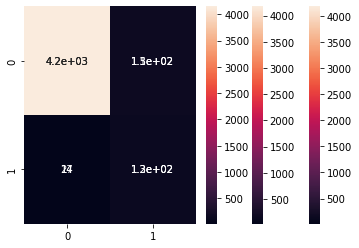

In [28]:
runCrossVal(lines_pad, data["vul"].values, max_len, num_words, dim, seed, embedding_matrix, "lstm")